## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
df_flights = pd.read_csv('flights.csv')
df_delays = pd.read_csv('delays.csv')
df_flights_test = pd.read_csv('flights_test.csv')

In [21]:
plt.style.use('seaborn')

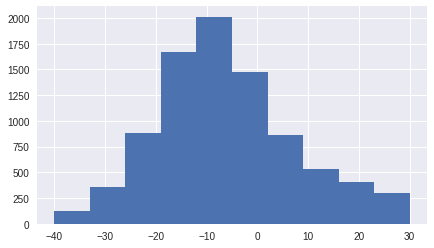

In [22]:
fig, ax = plt.subplots(1, figsize=(7,4))

ax.hist(df_flights['arr_delay'], range=(-40,30))
# ax.set_title('Arrival Delay Distribution')
# ax.set_xlabel('Delay in Minutes')
# ax.set_ylabel('Frequency of Delay')
fig.savefig('Delay_Normal_Distribution.jpg')

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [23]:
df_delays['month'] = df_delays['fl_date'].str[5:7]

In [24]:
data = df_delays.groupby(by='month')['arr_delay'].mean().to_dict()

In [25]:
data

{'01': 41.81958041958042,
 '02': 40.010230179028135,
 '03': 32.78934010152284,
 '04': 39.72845953002611,
 '05': 39.84251101321586,
 '06': 45.42829076620825,
 '07': 48.16561181434599,
 '08': 45.01791359325606,
 '09': 35.763425253991294,
 '10': 33.87264150943396,
 '11': 36.737206085753805,
 '12': 39.59006928406467}

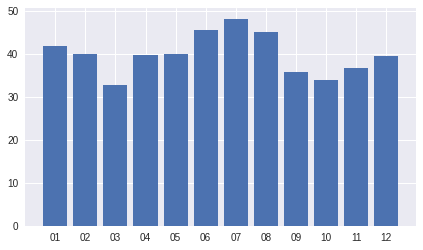

In [26]:
fig, ax = plt.subplots(1, figsize=(7,4))

ax.bar(data.keys(), data.values())
# ax.set_title('Month and Delay Correlation')
# ax.set_xlabel('Month')
# ax.set_ylabel('Average Delay')
fig.savefig('Month_Delay_Correlation.jpg')

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [9]:
import requests
import os
from IPython.display import JSON

api_key = os.environ['VISUAL_CROSSING']

In [10]:
#### REFORMAT DATE AND TIME FOR VISUAL CROSSING

def format_departure_time(x):
    str_time = str(x['crs_dep_time'])
    new_time = str_time.rjust(4, '0')
    return x['fl_date'] + 'T' + new_time[0:2] + ':' + new_time[2:4] + ':00'

def format_arrival_time(x):
    str_time = str(x['crs_arr_time'])
    new_time = str_time.rjust(4, '0')
    return x['fl_date'] + 'T' + new_time[0:2] + ':' + new_time[2:4] + ':00'

df_delays['new_dep_time'] = df_delays.apply(format_departure_time, axis=1)
df_delays['new_arr_time'] = df_delays.apply(format_arrival_time, axis=1)

In [11]:
#### GET WEATHER FROM ORIGIN

def get_weather_origin(x):
    response = requests.get(
        'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history',
        params={
            'aggregateHours': '1',
            'startDateTime': x['new_dep_time'],
            'unitGroup': 'us',
            'contentType': 'json',
            'locations': x['origin_city_name'],
            'key': api_key
        }
    )
    
    if response.status_code == 200:
        json = response.json()
        for i in json['locations'].values():
            for j in i['values']:
                return j['conditions']

In [12]:
#### GET WEATHER FROM DESTINATION

def get_weather_destination(x):
    response = requests.get(
        'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history',
        params={
            'aggregateHours': '1',
            'startDateTime': x['new_arr_time'],
            'unitGroup': 'us',
            'contentType': 'json',
            'locations': x['dest_city_name'],
            'key': api_key
        }
    )
    
    if response.status_code == 200:
        json = response.json()
        for i in json['locations'].values():
            for j in i['values']:
                return j['conditions']

In [13]:
tmp_df = df_delays.iloc[500:505,:].copy()
tmp_df['weather_condition_origin'] = tmp_df.apply(get_weather_origin, axis=1)
tmp_df['weather_condition_dest'] = tmp_df.apply(get_weather_destination, axis=1)

In [14]:
tmp_df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,new_dep_time,new_arr_time,weather_condition_origin,weather_condition_dest
500,2018-03-04,DL,DL_CODESHARE,DL,5703,CP,N629CZ,5703,14869,SLC,...,NaN,NaN,NaN,NaN,NaN,03,2018-03-04T22:05:00,2018-03-04T23:08:00,Overcast,Clear
501,2019-08-26,WN,WN,WN,994,WN,N423WN,994,13232,MDW,...,0.0,NaN,NaN,NaN,NaN,08,2019-08-26T21:00:00,2019-08-26T00:35:00,Overcast,Clear
502,2018-02-20,DL,DL_CODESHARE,DL,3374,9E,N605LR,3374,13487,MSP,...,34.0,NaN,NaN,NaN,NaN,02,2018-02-20T14:25:00,2018-02-20T17:09:00,Overcast,"Rain, Overcast"
503,2018-03-01,B6,B6,B6,687,B6,N935JB,687,10721,BOS,...,0.0,NaN,NaN,NaN,NaN,03,2018-03-01T18:16:00,2018-03-01T21:57:00,Overcast,Overcast
504,2018-08-13,AA,AA,AA,1560,AA,N138AN,1560,11298,DFW,...,9.0,NaN,NaN,NaN,NaN,08,2018-08-13T12:53:00,2018-08-13T16:36:00,Partially cloudy,Overcast


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [15]:
df_delays['dep_time_HH'] = df_delays['dep_time'] // 100
df_delays['dep_time_HH'].describe()

count    10000.000000
mean        14.174600
std          5.051977
min          0.000000
25%         10.000000
50%         15.000000
75%         18.000000
max         24.000000
Name: dep_time_HH, dtype: float64

In [16]:
df_delays['dep_time_HH'] = df_delays['dep_time_HH'].replace(24.0, 0.0)

In [17]:
df_delays.groupby(by='dep_time_HH')['taxi_out'].mean()

dep_time_HH
0.0     16.636364
1.0     16.800000
2.0     11.750000
3.0     14.000000
4.0     15.857143
5.0     22.020202
6.0     23.471605
7.0     24.737778
8.0     24.480638
9.0     23.637450
10.0    22.125000
11.0    21.499089
12.0    20.720539
13.0    20.244755
14.0    20.569231
15.0    21.000000
16.0    22.452119
17.0    22.115493
18.0    21.761151
19.0    19.925329
20.0    21.629687
21.0    19.619369
22.0    19.175573
23.0    18.328431
Name: taxi_out, dtype: float64

In [18]:
df_delays.groupby(by='dep_time_HH')['taxi_in'].mean()

dep_time_HH
0.0      8.051948
1.0      8.300000
2.0     10.750000
3.0     12.500000
4.0     10.428571
5.0     11.611111
6.0     10.350617
7.0     10.368889
8.0      9.845103
9.0      9.015936
10.0     8.556452
11.0     8.834244
12.0     8.946128
13.0     8.660839
14.0     8.683077
15.0     8.891847
16.0     8.676609
17.0     9.070423
18.0     9.538129
19.0     8.368960
20.0     8.321875
21.0     8.173423
22.0     6.720102
23.0     7.357843
Name: taxi_in, dtype: float64

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [19]:
df_delays['dep_minus_arr_delay'] = df_delays['dep_delay'] - df_delays['arr_delay']

(array([ 129.,  265.,  585., 1564., 2794., 2467., 1569.,  410.,   56.,
          14.]),
 array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <BarContainer object of 10 artists>)

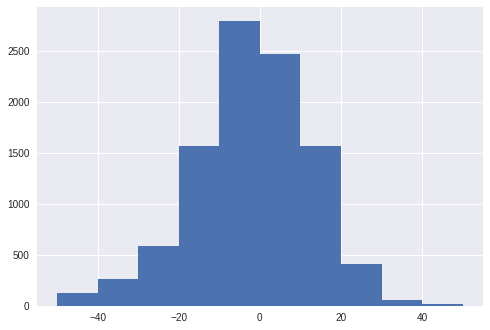

In [20]:
plt.hist(df_delays['dep_minus_arr_delay'], range=(-50, 50))

In [21]:
df_delays['dep_minus_arr_delay'].describe()

count    9996.000000
mean       -3.398960
std        16.656134
min      -198.000000
25%       -11.000000
50%        -2.000000
75%         8.000000
max        51.000000
Name: dep_minus_arr_delay, dtype: float64

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?